### Step 0: Import libraries and split train/test data

In [1]:
#!pip install scikit-learn
#!pip install seaborn
#!pip install imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 13.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
import pandas as pd
import numpy

# These two have been choosen according to the official description of the scikit website: https://scikit-learn.org/stable/modules/naive_bayes.html
from sklearn.naive_bayes import MultinomialNB
# This one is especially useful for imbalanced dataset according to the source
from sklearn.naive_bayes import ComplementNB
# Classic Logistic Regression
from sklearn.linear_model import LogisticRegression
# Nearest Neighbor
from sklearn.neighbors import KNeighborsClassifier
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
# Passive Aggressive Classifier
from sklearn.linear_model import PassiveAggressiveClassifier
# Gradient Boosting Classifier
from sklearn.ensemble import HistGradientBoostingClassifier
# MLP as in Neural Network from SKLearn
from sklearn.neural_network import MLPClassifier
# Tensforflow for Neural Network ML
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
# Check if GPU is being recognized
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# Visualizing libraries
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Reading in the file for model training and testing
Steam_Reviews = pd.read_csv("Cleaned_Steam_Reviews.csv")

2024-06-07 13:14:29.971348: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 13:14:31.611275: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-06-07 13:14:31.611453: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-06-07 13:14:31.611469: W tensorfl

Num GPUs Available:  1


A small subset of the original dataset has been taken for certain algorithms, because otherwise the kernel would die because of the lack of computational ressources and generally the algorithms being ressource intensive.

In [2]:
# Subset with 50k reviews per sentiment

Steam_Reviews_Subset = pd.DataFrame()
for sentiment in Steam_Reviews["Recommended"].unique():
    subset = Steam_Reviews[Steam_Reviews["Recommended"] == sentiment].sample(n = 50000, random_state = 97) # sample command is great to create subsets
    Steam_Reviews_Subset = pd.concat([Steam_Reviews_Subset, subset])
    
# Steam_Reviews = Steam_Reviews_Subset

### Dealing with imbalance

In order to see if the heavy imbalance has a significant impact on predicting the sentiment, downsampling will be used.

In [2]:
# The actual resampling happens here
Steam_positive = Steam_Reviews[Steam_Reviews["Recommended"] == 1]
Steam_negative = Steam_Reviews[Steam_Reviews["Recommended"] == 0]

# The actual downsampling
temp = resample(Steam_positive, replace = False, n_samples = len(Steam_negative), random_state = 97)

# Combining the reviews again
Steam_Reviews = pd.concat([temp, Steam_negative])

print(Steam_Reviews["Recommended"].value_counts())

Recommended
True     98555
False    98555
Name: count, dtype: int64


Step by Step Workflow:

1. Splitting the data into test and training data based on features (Reviews) and labels (Recommendation).
2. Vectorizing the data from text to numerical representations of aforementioned text
3. Initialize and train the model
4. Predict the results with the trained model
5. Evaluation based on performance metrics

In [3]:
# Split into test and train data: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, Y_train, Y_test = train_test_split(Steam_Reviews["Review"], Steam_Reviews["Recommended"], test_size = 0.2, random_state = 27)

# Convert a collection of text documents (Steam Reviews in this case) to a matrix of token counts: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html 
vector = TfidfVectorizer()
# Transformation happens with the same vectorizer instance, hence why first the fit_transform command is used and then only transform. This is done to prevent a dimensionalitiy mismatch error.
X_train_vector = vector.fit_transform(X_train)
X_test_vector = vector.transform(X_test)

# Arrays to be used for certain ML Algorithms
X_train_array = X_train_vector.toarray()
X_test_array = X_test_vector.toarray()

In [4]:
# This helps adjusting the weights accordingly
weights = Y_train.value_counts().to_dict()
weights

{True: 78872, False: 78816}

This code will be reused to visualize the confusion matrix for each sklearn method.

In [5]:
def visuals(cm, ML_type):
    plt.figure(figsize = (8,6))
    sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels = ["Negative", "Positive"], yticklabels = ["Negative", "Positive"])
    plt.ylabel("True Labels")
    plt.xlabel("Predicted Labels")
    plt.title("Confusion Matrix for " + ML_type)

In [6]:
def MachineLearning(model, model_name, data_type = "sparse", weights = weights):
    if data_type == "sparse":
        model.fit(X_train_vector, Y_train)
    else:
        model.fit(X_train_array, Y_train)

    # Prediciting the values
    if data_type == "sparse":
        Y_prediction = model.predict(X_test_vector)
    else:
        Y_prediction = model.predict(X_test_array)

    # Evaluating the model
    acc = accuracy_score(Y_test, Y_prediction)
    print("Accuaracy Score: ", acc)
    
    if model_name == "Random Forest":
        f1score = f1_score(Y_test, Y_prediction)
        print("F1 Score: ", f1score)

    # Checking the value counts for validity and potential overfitting
    test = pd.DataFrame({"Predicted Sentiment": Y_prediction})
    print(test["Predicted Sentiment"].value_counts())

    # Confusion Matrix
    cm_1 = confusion_matrix(Y_test, Y_prediction)

    # Visuals
    visuals(cm_1, model_name)
    return model

### 1. Naive Bayes (scikit-learn): Multinomial

Source: https://scikit-learn.org/stable/modules/naive_bayes.html

Accuaracy Score:  0.8777586119425701
Predicted Sentiment
True     19918
False    19504
Name: count, dtype: int64
CPU times: user 232 ms, sys: 80.3 ms, total: 312 ms
Wall time: 256 ms


MultinomialNB()

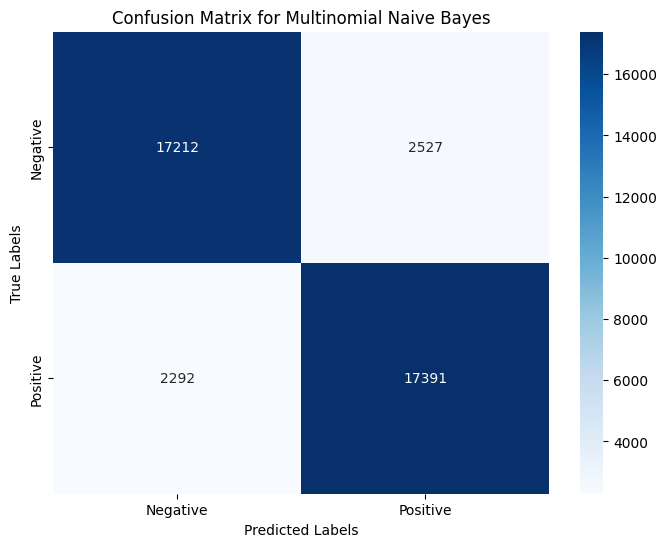

In [7]:
%%time
# Using the MultinomialNB: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
MultiNB = MultinomialNB()
MachineLearning(MultiNB, "Multinomial Naive Bayes")

### 2. Naive Bayes (scikit-learn): Complement

Source: https://scikit-learn.org/stable/modules/naive_bayes.html

Accuaracy Score:  0.8751458576429405
Predicted Sentiment
True     19733
False    19689
Name: count, dtype: int64
CPU times: user 203 ms, sys: 60 ms, total: 263 ms
Wall time: 196 ms


ComplementNB()

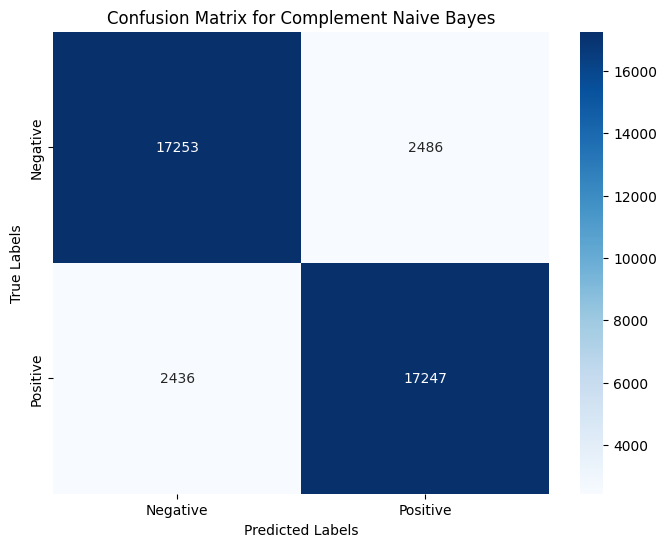

In [8]:
%%time
# Using the ComplementNB: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html
ComplNB = ComplementNB()
MachineLearning(ComplNB, "Complement Naive Bayes")

### 3. Logistic Regression (scikit-learn)

Source: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Accuaracy Score:  0.8864339708792045
Predicted Sentiment
True     19954
False    19468
Name: count, dtype: int64
CPU times: user 7min 2s, sys: 21min 31s, total: 28min 33s
Wall time: 2min 23s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight={False: 78816, True: 78872}, max_iter=5000,
                   random_state=27)

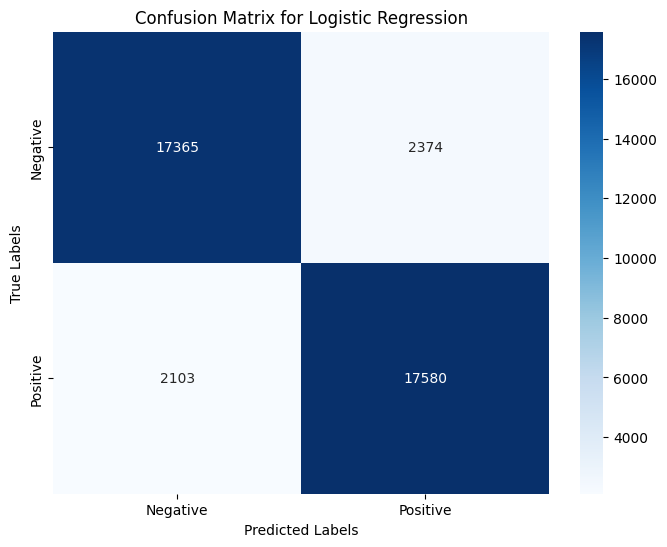

In [9]:
%%time
# Initializing the logistic regression
LogReg = LogisticRegression(random_state = 27, max_iter = 5000, class_weight = weights)
MachineLearning(LogReg, "Logistic Regression")

### 4. K-Nearest Neighbors (scikit-learn)

Source: https://scikit-learn.org/stable/modules/neighbors.html

Accuaracy Score:  0.783344325503526
Predicted Sentiment
True     26020
False    13402
Name: count, dtype: int64
CPU times: user 34min 28s, sys: 1.55 s, total: 34min 30s
Wall time: 3min 9s


KNeighborsClassifier()

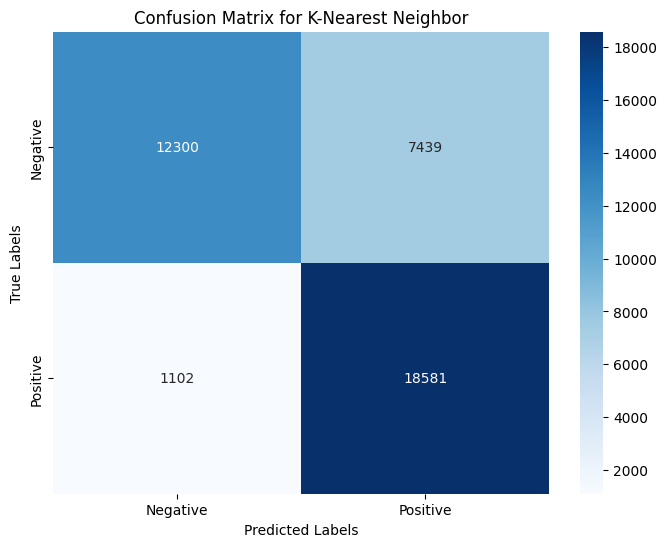

In [10]:
%%time
# Initializing the KNN
KNNModel = KNeighborsClassifier()
MachineLearning(KNNModel, "K-Nearest Neighbor")

### 5. Random Forest (scikit-learn)

Source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Accuaracy Score:  0.9007407031606717
F1 Score:  0.9004908069068993
Predicted Sentiment
False    19782
True     19640
Name: count, dtype: int64
CPU times: user 11min 5s, sys: 576 ms, total: 11min 6s
Wall time: 11min 6s


RandomForestClassifier(class_weight={False: 78816, True: 78872},
                       random_state=27)

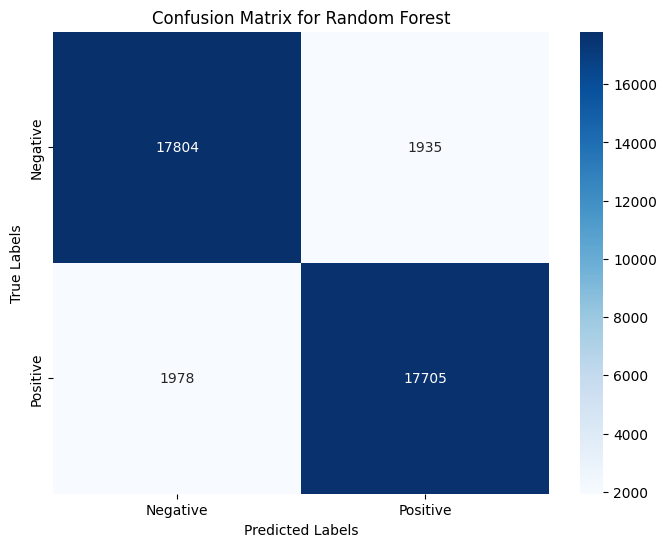

In [11]:
%%time
# Initializing the Random Forest
RFModel = RandomForestClassifier(random_state = 27, class_weight = weights)
MachineLearning(RFModel, "Random Forest")

### 6. Passive Aggressive Classifier (scikit-learn)

Source: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PassiveAggressiveClassifier.html

Accuaracy Score:  0.8502105423367663
Predicted Sentiment
True     20460
False    18962
Name: count, dtype: int64
CPU times: user 1.45 s, sys: 702 ms, total: 2.16 s
Wall time: 1.32 s


PassiveAggressiveClassifier(class_weight={False: 78816, True: 78872},
                            random_state=27)

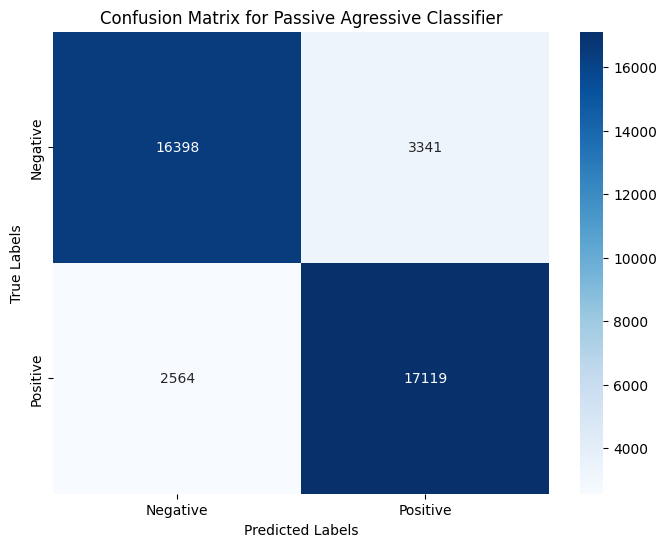

In [12]:
%%time
PAC = PassiveAggressiveClassifier(random_state = 27, class_weight = weights)
MachineLearning(PAC, "Passive Agressive Classifier")

### 7. Gradient Boosting Classifier (scikit-learn)

#### Subset used!


Source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html#sklearn.ensemble.HistGradientBoostingClassifier

Does not run without kernel dying when using a big dataset.

Accuaracy Score:  0.77265
Predicted Sentiment
True     12645
False     7355
Name: count, dtype: int64
CPU times: user 4min 51s, sys: 5.35 s, total: 4min 56s
Wall time: 51.9 s


HistGradientBoostingClassifier(max_depth=2, max_iter=50, max_leaf_nodes=10)

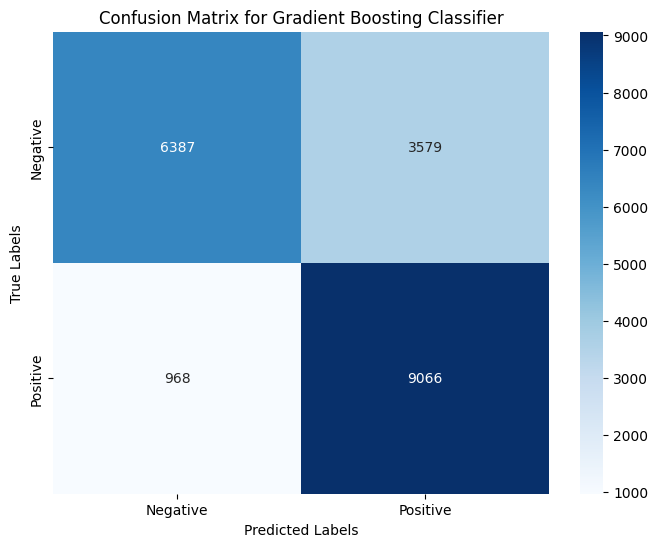

In [7]:
%%time
GBC = HistGradientBoostingClassifier(max_iter = 50, max_depth = 2, max_leaf_nodes = 10)
MachineLearning(GBC, "Gradient Boosting Classifier", data_type = "dense")

### 8. Scikitlearn and Neural Networks

Source: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

Accuaracy Score:  0.9021104966769824
Predicted Sentiment
False    19922
True     19500
Name: count, dtype: int64
CPU times: user 1h 34min 13s, sys: 4h 43min 50s, total: 6h 18min 3s
Wall time: 33min 30s


MLPClassifier(max_iter=1000, random_state=27)

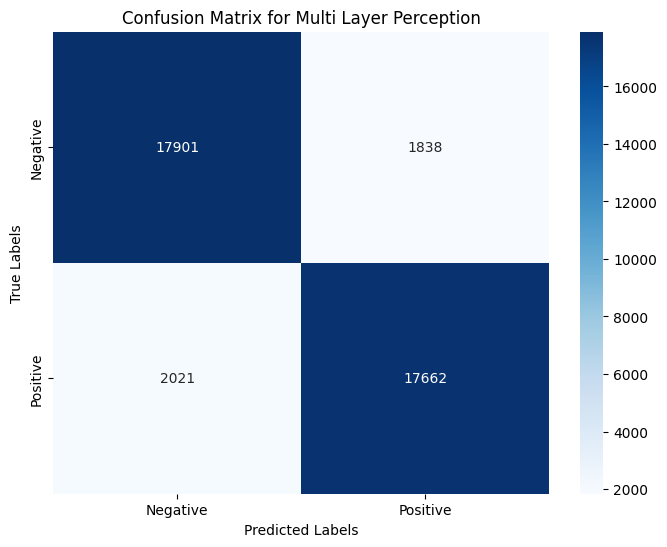

In [14]:
%%time
MLP = MLPClassifier(random_state = 27, hidden_layer_sizes = (100,), max_iter = 1000)
MachineLearning(MLP, "Multi Layer Perception")

Accuaracy Score:  0.8966313226117396
Predicted Sentiment
True     19952
False    19470
Name: count, dtype: int64
CPU times: user 1h 18min 7s, sys: 3h 45min 16s, total: 5h 3min 23s
Wall time: 25min 47s


MLPClassifier(hidden_layer_sizes=(100, 50), random_state=27)

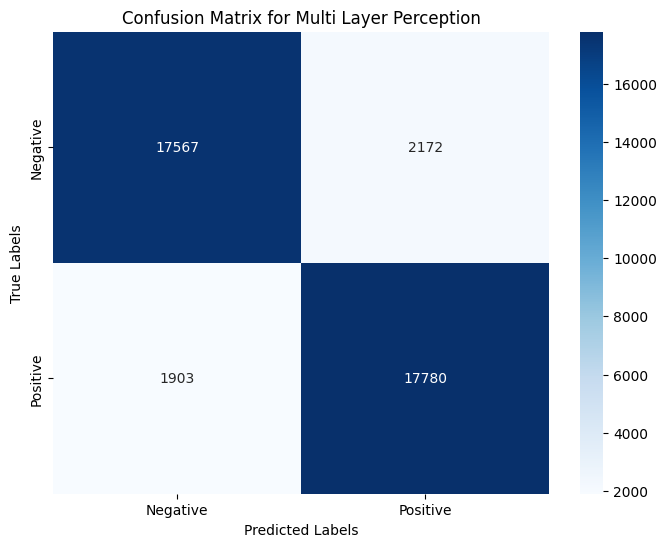

In [15]:
%%time
MLP = MLPClassifier(random_state = 27, hidden_layer_sizes = (100,50))
MachineLearning(MLP, "Multi Layer Perception")

Accuaracy Score:  0.898635279793009
Predicted Sentiment
True     19911
False    19511
Name: count, dtype: int64
CPU times: user 1h 55min 54s, sys: 5h 49min 3s, total: 7h 44min 57s
Wall time: 38min 52s


MLPClassifier(hidden_layer_sizes=(200, 100), random_state=27)

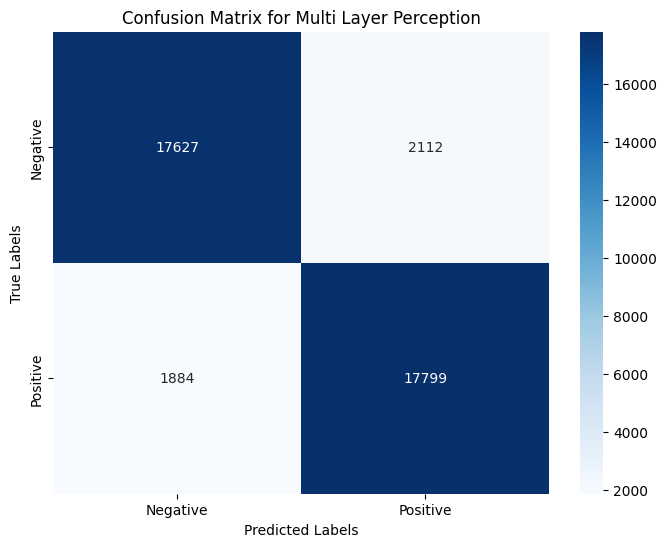

In [16]:
%%time
MLP = MLPClassifier(random_state = 27, hidden_layer_sizes = (200,100))
MachineLearning(MLP, "Multi Layer Perception")

### 9. Tensorflow and Recurrent Neural Networks

Source: https://www.tensorflow.org/tutorials/keras/text_classification <br>
Source: https://www.tensorflow.org/text/tutorials/text_classification_rnn <br>
Source: https://www.tensorflow.org/guide/keras/understanding_masking_and_padding <br>
Source: https://www.tensorflow.org/guide/keras/working_with_rnns <br>

Step 9 will focus on Recurrent neural networks. It will use a Bidirectional LSTM Layer and dense layers to predict the sentiment of these reviews.

In [7]:
# Seperating the label and features columns 
label = Steam_Reviews.pop("Recommended")
feature = Steam_Reviews["Review"]

# Converting it to tensor objects for better performance and results
feature = tf.convert_to_tensor(feature)
label = tf.convert_to_tensor(label)

# Uniting the columns
dataset = tf.data.Dataset.from_tensor_slices((feature, label))

# Creating test and train datasets
train_size = int(0.8 * len(feature))  # 80% for training
test_size = len(feature) - train_size  # Remaining 20% for testing

# Shuffling
dataset = dataset.shuffle(buffer_size=len(feature))

# The actual train/test datasets
train_dataset = dataset.take(train_size)  
test_dataset = dataset.skip(train_size) 

# Preparing the datasets for modelling
Buffer_size = 10000
batch_size = 32

train_dataset = train_dataset.shuffle(Buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

2024-06-07 13:14:44.302332: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 13:14:45.018643: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22173 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:41:00.0, compute capability: 8.0


In [8]:
# Initialize empty lists to store features and labels
all_test_features = []
all_test_labels = []

# Using a for loop to iterate over the dataset, extracting both features and labels to use for the prediction part
for features, labels in test_dataset:
    all_test_features.append(features)
    all_test_labels.append(labels)

# Concatenate all the extracted values into a tensorflow variable
test_features = tf.concat(all_test_features, axis=0)
test_labels = tf.concat(all_test_labels, axis=0)

In [9]:
# Defining the accuracy variable to evaulate the tensor models
accuracy = tf.keras.metrics.Accuracy()

In [10]:
# Taken from: https://www.tensorflow.org/text/tutorials/text_classification_rnn

VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)

# Memory usage always killed the kernel, which is why a smaller subset was decided to be implemented
# This basically "ignores" less frequent words in order to save memory, once again finding the golden middle is key here
subset_size = 1000
subset = train_dataset.take(subset_size)

# Training on the subset
encoder.adapt(subset.map(lambda text, label: text))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Notes for Neural Networks and the Code:

1. Validation data is used to finetune the model after every epoch by minimizing the loss variable. The loss variable basically measures the difference between predicted outcomes and actual true labeling. This is a great way to see if overfitting happens or the model generally performs terribly. Loss is being calcuated by the BinaryCrossEntropy function. The formula can be found on the official tensorflow website or in the thesis that this code is based on. <br>
2. Validation steps is used for specifying how many batches of validation data to return from a generator function. Very useful when dealing with very big datasets, which do not fit in the RAM of the system. <br>
3. Bidirectional LSTM is used to handle sequential data effectively by memorizing long term dependencies. And since it is bidirectional, it learns from both future and past context. 
4. Emebdding uses the length of the vocabulary as the input dimension.

Note: Sometimes during training the code would simply stop working without an error message. Reducing the epochs to 5 was introduced to counteract longer training sessions.

In [11]:
%%time
# Initiliaze the model by defining the different layers
RNNModel = tf.keras.Sequential([encoder, 
                                tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero = True), 
                                tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                                tf.keras.layers.Dropout(0.2),
                                tf.keras.layers.Dense(64, activation = "relu"),
                                tf.keras.layers.Dense(1)])
                               
RNNModel.compile(loss = tf.keras.losses.BinaryCrossentropy(),  # These parameters were taken from https://www.tensorflow.org/text/tutorials/text_classification_rnn
               optimizer=tf.keras.optimizers.Adam(1e-4),
               metrics = ["accuracy"])

# This is where the actual model training happens
Trained_RNNModel = RNNModel.fit(train_dataset, epochs = 5, validation_data = test_dataset, validation_steps = 30)     # Definition of which arrays are to be passed and how many epochs (or rounds) the training should include. Each epoch counts as an iteration over the entire dataset.

Epoch 1/5


2024-06-07 13:14:57.454059: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'cond_40/output/_23'
2024-06-07 13:14:59.377270: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2024-06-07 13:14:59.555973: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-06-07 13:14:59.560601: I tensorflow/compiler/xla/servic

4928/4928 [==============================] - 261s 51ms/step - loss: 0.4907 - accuracy: 0.7800 - val_loss: 0.2792 - val_accuracy: 0.8750
Epoch 2/5
4928/4928 [==============================] - 142s 29ms/step - loss: 0.3217 - accuracy: 0.8698 - val_loss: 0.3277 - val_accuracy: 0.8781
Epoch 3/5
4928/4928 [==============================] - 140s 28ms/step - loss: 0.3056 - accuracy: 0.8806 - val_loss: 0.3112 - val_accuracy: 0.8823
Epoch 4/5
4928/4928 [==============================] - 139s 28ms/step - loss: 0.2916 - accuracy: 0.8839 - val_loss: 0.3251 - val_accuracy: 0.8656
Epoch 5/5
4928/4928 [==============================] - 139s 28ms/step - loss: 0.2897 - accuracy: 0.8840 - val_loss: 0.2830 - val_accuracy: 0.8938
CPU times: user 19min 22s, sys: 1min 48s, total: 21min 10s
Wall time: 13min 43s


In [12]:
# Evaluating the model on both accuracy and loss
Y_prediction = RNNModel.predict(test_features, batch_size = batch_size)
Y_prediction_RNN = (Y_prediction > 0.5).astype(int)                # Because of the sigmoid function, the values will be between 0 and 1. In order to use a confusion matrix, the values will be converted to either 0 or 1.

1232/1232 [==============================] - 17s 11ms/step


In [13]:
# Accuracy and loss values for the last epoch of the model training
print("Test loss: ", Trained_RNNModel.history["loss"][4])
print("Test acc: ", Trained_RNNModel.history["accuracy"][4])

Test loss:  0.28966185450553894
Test acc:  0.8839734196662903


In [14]:
# Accuracy of the predicted values for the model
accuracy.update_state(test_labels, Y_prediction_RNN)
print("Accuaracy Score: ", accuracy.result().numpy())

Accuaracy Score:  0.89026433


### 10. Tensorflow and Convolutional Neural Networks

Source: https://www.tensorflow.org/tutorials/images/cnn

Step 10 will focus on CNNs. The code pretty much will stay unchanged besides the LSTM layer being replaced by a convulational layer.
As mentioned above, CNN is usually excelling at visual computing tasks, keep that in mind.

In [15]:
%%time
# Initiliaze the model by defining the different layers
CNNModel = tf.keras.Sequential([encoder,
                               tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero = True), 
                               tf.keras.layers.Conv1D(64, 5, activation = "relu"),         # A one dimensional (No images, only text, thus 1 dimension) convolutional layer. 64 describes the number of kernels in the layer. Each kernel learns to detect patterns. Imagine it like 64 children learning patterns.
                               tf.keras.layers.Dropout(0.2),                                # Randomly dropping 20% of the input data to prevent overfitting 
                               tf.keras.layers.GlobalMaxPooling1D(),                       # The 5 from the line above describes how many adjacent tokens are being considered in the pattern recognition at the same time. Pooling describes reduction of dimensionality while reatining the most important features-
                               tf.keras.layers.Dense(32, activation = "relu"),
                               tf.keras.layers.Dense(1, activation = "sigmoid")])
                               
CNNModel.compile(loss = tf.keras.losses.BinaryCrossentropy(),  # These parameters were taken from https://www.tensorflow.org/text/tutorials/text_classification_rnn (Can also be used for CNN, since BinaryCrossentropy is used for binary labels (in this case, recommended or not recommended)
               optimizer = "adam",
               metrics = ["accuracy"])

# This is where the actual model training happens
Trained_CNNModel = CNNModel.fit(train_dataset, epochs = 5,       # Definition of which arrays are to be passed and how many epochs (or rounds) the training should include. Each epoch counts as an iteration over the entire dataset.
                           validation_data = test_dataset,       # The validation_data requires not only labels, but also validation data. This is because after each epoch, the validation data is used to evalute the model in its current state.                           
                           validation_steps = 30)                # Additionally in the source, there is also a command called validation steps. This specifies how many batches we want to use from our entire dataset.

Epoch 1/5
4928/4928 [==============================] - 123s 24ms/step - loss: 0.2833 - accuracy: 0.8755 - val_loss: 0.2591 - val_accuracy: 0.8813
Epoch 2/5
4928/4928 [==============================] - 32s 6ms/step - loss: 0.2481 - accuracy: 0.8925 - val_loss: 0.2338 - val_accuracy: 0.9000
Epoch 3/5
4928/4928 [==============================] - 31s 6ms/step - loss: 0.2323 - accuracy: 0.9001 - val_loss: 0.2192 - val_accuracy: 0.9115
Epoch 4/5
4928/4928 [==============================] - 28s 6ms/step - loss: 0.2245 - accuracy: 0.9040 - val_loss: 0.2003 - val_accuracy: 0.9125
Epoch 5/5
4928/4928 [==============================] - 28s 6ms/step - loss: 0.2150 - accuracy: 0.9078 - val_loss: 0.2172 - val_accuracy: 0.9115
CPU times: user 5min 18s, sys: 23.9 s, total: 5min 42s
Wall time: 4min 2s


In [16]:
# Evaluating the model on both accuracy and loss
Y_prediction = CNNModel.predict(test_features, batch_size = batch_size)
Y_prediction_CNN = (Y_prediction > 0.5).astype(int)                # Because of the sigmoid function, the values will be between 0 and 1. In order to use a confusion matrix, the values will be converted to either 0 or 1.

1232/1232 [==============================] - 3s 2ms/step


In [17]:
print("Test loss: ", Trained_CNNModel.history["loss"][4])
print("Test acc: ", Trained_CNNModel.history["accuracy"][4])

Test loss:  0.21497415006160736
Test acc:  0.9078369736671448


In [18]:
accuracy.update_state(test_labels, Y_prediction_CNN)
print("Accuracy:", accuracy.result().numpy())

Accuracy: 0.905015


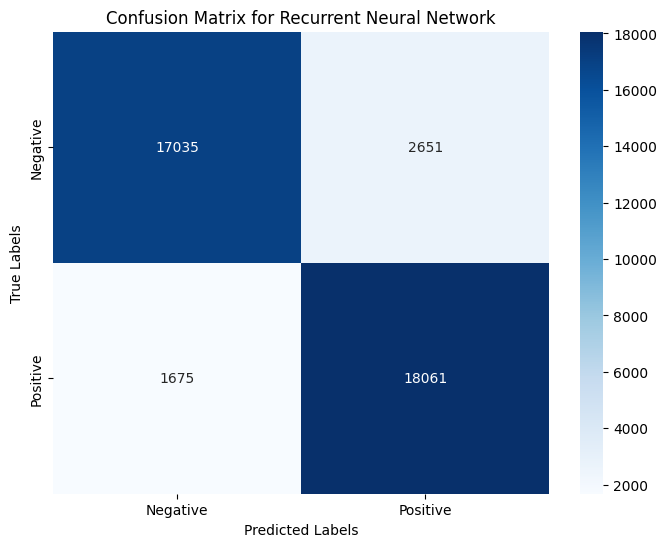

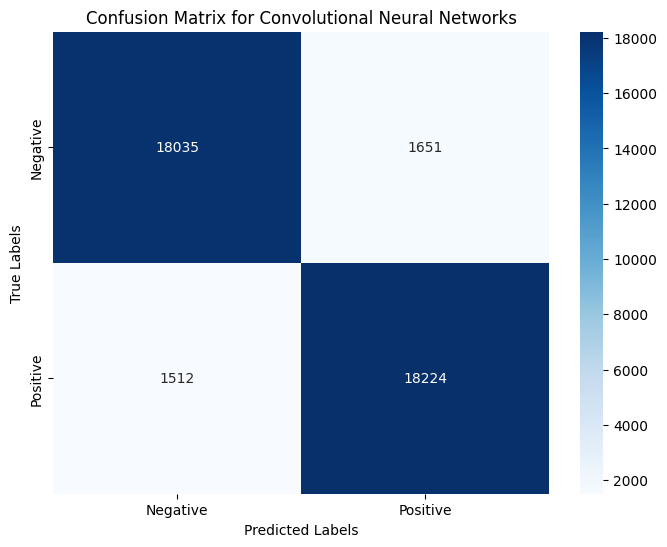

In [19]:
# Visualizing using a Confusion Matrix

# Confusion Matrix
cm_7 = confusion_matrix(test_labels, Y_prediction_RNN)
cm_8 = confusion_matrix(test_labels, Y_prediction_CNN)

# Visuals
visuals(cm_7, "Recurrent Neural Network")
visuals(cm_8, "Convolutional Neural Networks")

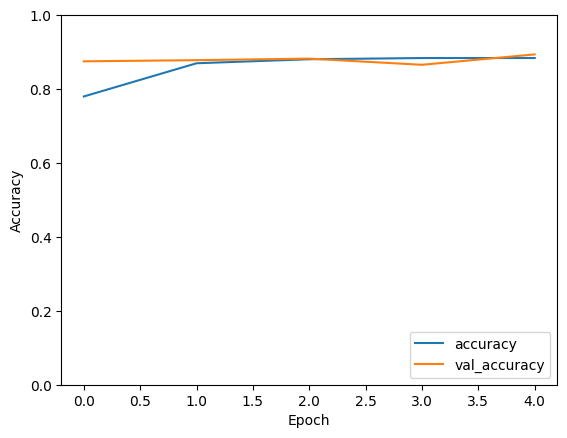

In [20]:
# Line Graph
# Taken from https://www.tensorflow.org/tutorials/images/cnn

plt.plot(Trained_RNNModel.history['accuracy'], label='accuracy')
plt.plot(Trained_RNNModel.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

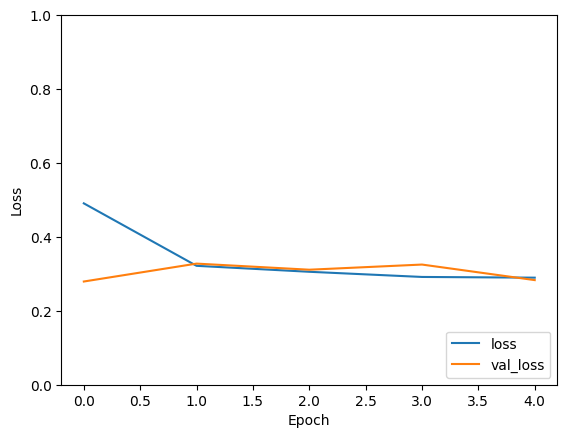

In [21]:
plt.plot(Trained_RNNModel.history['loss'], label = 'loss')
plt.plot(Trained_RNNModel.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

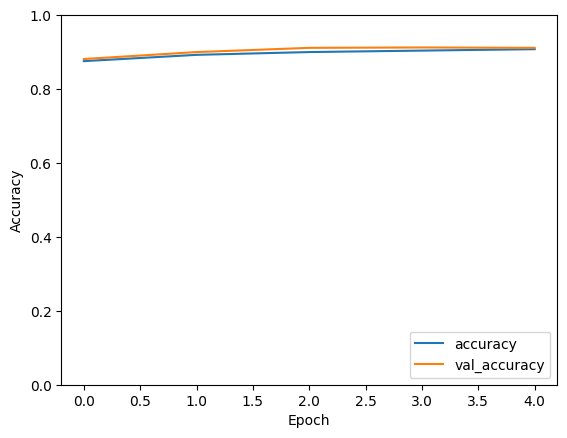

In [22]:
# Line Graph
# Taken from https://www.tensorflow.org/tutorials/images/cnn

plt.plot(Trained_CNNModel.history['accuracy'], label='accuracy')
plt.plot(Trained_CNNModel.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

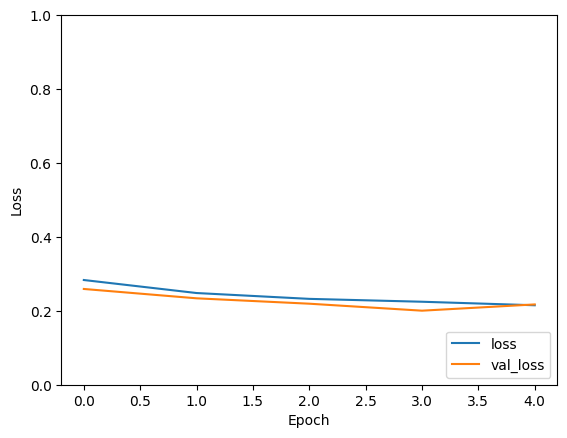

In [23]:
plt.plot(Trained_CNNModel.history['loss'], label = 'loss')
plt.plot(Trained_CNNModel.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')